### Cake Eating (Single Agent)

- Infinite horizons problem
- There is a single agent that wants to eat a cake. 
- There is one state $s$ that is the total cake left.
- There is one action $a$ that is how much to eat each turn.
- Reward: $r(a) = \frac{a^{1-\rho}-1}{1-\rho}$ if $a \in [0,s]$, else 1000.
- State evolution: $s' = s-a$
- $Q(s,a) = r(a) + \gamma Q(s,a)$

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [13]:
def gameReward(a,s,rho):
    if 0<a<s:
        return (a**(1-rho)-1)/(1-rho)
    else:
        return -1000
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','r1'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State, Output: Value of actions (0/1)
    # Network predicts the expected Return of taking each action given the state
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    try:
        state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    except:
        print(action_batch)
        print(policy_net(state_batch.reshape(-1,1)))
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')
        
    

### HyperParameters and Initializations

In [38]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.1 # Initial value of Epsilon (Exploration)
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
RHO = 2.0 # utility function parameter
n_obs = 1
n_actions = 20
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
steps_done1 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [39]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 1000


for t in range(epochs):
    state = torch.tensor(float(1),dtype=torch.float32).unsqueeze(0)
    print('Epoch',t)
    cnt = 0
    while state.item() > 1e-2:
        print('\n Iteration:',cnt)

        # Take action
        a1 = select_action(state, policy_net1, 0)
        a1_cake = float(a1)/n_actions
        
        # Obtain Rewards
        r1 = gameReward(float(a1_cake), float(state), RHO)
        r1 = torch.tensor([r1])

        # Compute next state (which is the opponents' strategy)
        next_state = torch.tensor(float(state)-float(a1_cake),dtype=torch.float32).unsqueeze(0)

        # store memory in transition
        memory.push(state,next_state,a1,r1)

        # move to next state
        state = next_state

        # optimize
        optimize_model(policy_net1,target_net1, 0)

        # soft update target_net
        update_target_net(target_net1, policy_net1)

        # record actions
        actions.append([float(a1), float(state)])
        
        print(float(a1_cake),float(state))
        cnt += 1

Epoch 0

 Iteration: 0
0.2 0.800000011920929

 Iteration: 1
0.2 0.6000000238418579

 Iteration: 2
0.2 0.40000003576278687

 Iteration: 3
0.2 0.20000003278255463

 Iteration: 4
0.2 3.278255533700758e-08
Epoch 1

 Iteration: 0
0.0 1.0

 Iteration: 1
0.2 0.800000011920929

 Iteration: 2
0.2 0.6000000238418579

 Iteration: 3
0.2 0.40000003576278687

 Iteration: 4
0.05 0.3500000238418579

 Iteration: 5
0.2 0.15000002086162567

 Iteration: 6
0.2 -0.04999997839331627
Epoch 2

 Iteration: 0
0.2 0.800000011920929

 Iteration: 1
0.2 0.6000000238418579

 Iteration: 2
0.2 0.40000003576278687

 Iteration: 3
0.2 0.20000003278255463

 Iteration: 4
0.2 3.278255533700758e-08
Epoch 3

 Iteration: 0
0.2 0.800000011920929

 Iteration: 1
0.2 0.6000000238418579

 Iteration: 2
0.2 0.40000003576278687

 Iteration: 3
0.05 0.3500000238418579

 Iteration: 4
0.2 0.15000002086162567

 Iteration: 5
0.2 -0.04999997839331627
Epoch 4

 Iteration: 0
0.2 0.800000011920929

 Iteration: 1
0.2 0.6000000238418579

 Iteratio

Loss Agent0:127.99320220947266
0.6 0.4000000059604645

 Iteration: 1
Loss Agent0:167.02626037597656
0.6 -0.19999998807907104
Epoch 40

 Iteration: 0
Loss Agent0:182.82601928710938
0.05 0.949999988079071

 Iteration: 1
Loss Agent0:190.16824340820312
0.6 0.3499999940395355

 Iteration: 2
Loss Agent0:151.46826171875
0.6 -0.25
Epoch 41

 Iteration: 0
Loss Agent0:151.52723693847656
0.6 0.4000000059604645

 Iteration: 1
Loss Agent0:205.7933807373047
0.6 -0.19999998807907104
Epoch 42

 Iteration: 0
Loss Agent0:175.00497436523438
0.6 0.4000000059604645

 Iteration: 1
Loss Agent0:167.0428466796875
0.6 -0.19999998807907104
Epoch 43

 Iteration: 0
Loss Agent0:190.22145080566406
0.6 0.4000000059604645

 Iteration: 1
Loss Agent0:167.0262908935547
0.6 -0.19999998807907104
Epoch 44

 Iteration: 0
Loss Agent0:174.2942657470703
0.6 0.4000000059604645

 Iteration: 1
Loss Agent0:151.35743713378906
0.6 -0.19999998807907104
Epoch 45

 Iteration: 0
Loss Agent0:182.0148162841797
0.6 0.4000000059604645

 Iter

Loss Agent0:244.27647399902344
0.85 0.15000000596046448

 Iteration: 1
Loss Agent0:220.79568481445312
0.85 -0.699999988079071
Epoch 86

 Iteration: 0
Loss Agent0:251.52139282226562
0.85 0.15000000596046448

 Iteration: 1
Loss Agent0:259.15399169921875
0.9 -0.75
Epoch 87

 Iteration: 0
Loss Agent0:306.2946472167969
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:252.15234375
0.75 -0.6499999761581421
Epoch 88

 Iteration: 0
Loss Agent0:251.93954467773438
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:306.1531677246094
0.75 -0.6499999761581421
Epoch 89

 Iteration: 0
Loss Agent0:236.18209838867188
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:298.1731872558594
0.75 -0.6499999761581421
Epoch 90

 Iteration: 0
Loss Agent0:321.64349365234375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:205.115966796875
0.75 -0.6499999761581421
Epoch 91

 Iteration: 0
Loss Agent0:275.0086669921875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:259.41864013671875
0.45 -0.3499999940395355


Loss Agent0:328.9559326171875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:351.9196472167969
0.05 0.05000000074505806

 Iteration: 2
Loss Agent0:328.888671875
0.9 -0.8500000238418579
Epoch 143

 Iteration: 0
Loss Agent0:320.7452697753906
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:336.07879638671875
0.9 -0.800000011920929
Epoch 144

 Iteration: 0
Loss Agent0:321.5733642578125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:289.4526062011719
0.9 -0.800000011920929
Epoch 145

 Iteration: 0
Loss Agent0:328.70196533203125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:375.6664733886719
0.9 -0.800000011920929
Epoch 146

 Iteration: 0
Loss Agent0:297.74847412109375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:328.8293762207031
0.85 -0.75
Epoch 147

 Iteration: 0
Loss Agent0:313.1885986328125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:336.88311767578125
0.85 -0.75
Epoch 148

 Iteration: 0
Loss Agent0:274.0445556640625
0.9 0.10000000149011612

 Iteration: 1
Lo

Loss Agent0:351.7204284667969
0.9 -0.800000011920929
Epoch 196

 Iteration: 0
Loss Agent0:304.8058166503906
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:359.87335205078125
0.9 -0.800000011920929
Epoch 197

 Iteration: 0
Loss Agent0:413.7453308105469
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:320.3780517578125
0.0 0.10000000149011612

 Iteration: 2
Loss Agent0:343.8087463378906
0.05 0.05000000074505806

 Iteration: 3
Loss Agent0:328.5535583496094
0.9 -0.8500000238418579
Epoch 198

 Iteration: 0
Loss Agent0:297.29058837890625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:350.8841857910156
0.9 -0.800000011920929
Epoch 199

 Iteration: 0
Loss Agent0:421.51953125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:390.76513671875
0.0 0.10000000149011612

 Iteration: 2
Loss Agent0:297.0792541503906
0.9 -0.800000011920929
Epoch 200

 Iteration: 0
Loss Agent0:328.3258972167969
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:398.2691955566406
0.9 -0.800000011920929
Epoch 20

Loss Agent0:359.09765625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:336.0135803222656
0.9 -0.800000011920929
Epoch 252

 Iteration: 0
Loss Agent0:366.72222900390625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:468.0480041503906
0.9 -0.800000011920929
Epoch 253

 Iteration: 0
Loss Agent0:358.9826965332031
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:397.4862060546875
0.9 -0.800000011920929
Epoch 254

 Iteration: 0
Loss Agent0:405.6496276855469
0.05 0.949999988079071

 Iteration: 1
Loss Agent0:436.7172546386719
0.9 0.049999989569187164

 Iteration: 2
Loss Agent0:437.121826171875
0.3 -0.25
Epoch 255

 Iteration: 0
Loss Agent0:397.8961181640625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:374.3623962402344
0.3 -0.20000000298023224
Epoch 256

 Iteration: 0
Loss Agent0:413.2718200683594
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:343.511962890625
0.3 -0.20000000298023224
Epoch 257

 Iteration: 0
Loss Agent0:405.36175537109375
0.9 0.10000000149011612

 Iterati

Loss Agent0:397.66339111328125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:311.69744873046875
0.9 -0.800000011920929
Epoch 309

 Iteration: 0
Loss Agent0:444.169921875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:327.45050048828125
0.9 -0.800000011920929
Epoch 310

 Iteration: 0
Loss Agent0:397.4548645019531
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:366.354248046875
0.9 -0.800000011920929
Epoch 311

 Iteration: 0
Loss Agent0:397.2998046875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:366.20196533203125
0.9 -0.800000011920929
Epoch 312

 Iteration: 0
Loss Agent0:420.5267333984375
0.05 0.949999988079071

 Iteration: 1
Loss Agent0:420.734130859375
0.9 0.049999989569187164

 Iteration: 2
Loss Agent0:358.2539367675781
0.3 -0.25
Epoch 313

 Iteration: 0
Loss Agent0:428.23883056640625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:382.0735778808594
0.9 -0.800000011920929
Epoch 314

 Iteration: 0
Loss Agent0:420.6171875
0.9 0.10000000149011612

 Iteration: 1
Los

0.2 -0.15000000596046448
Epoch 370

 Iteration: 0
Loss Agent0:357.4884338378906
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:474.08441162109375
0.2 -0.10000000149011612
Epoch 371

 Iteration: 0
Loss Agent0:427.46734619140625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:380.8757629394531
0.2 -0.10000000149011612
Epoch 372

 Iteration: 0
Loss Agent0:435.06671142578125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:489.28253173828125
0.2 -0.10000000149011612
Epoch 373

 Iteration: 0
Loss Agent0:381.0342712402344
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:349.87445068359375
0.2 -0.10000000149011612
Epoch 374

 Iteration: 0
Loss Agent0:396.28704833984375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:427.3891296386719
0.2 -0.10000000149011612
Epoch 375

 Iteration: 0
Loss Agent0:435.0055236816406
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:435.0384521484375
0.2 -0.10000000149011612
Epoch 376

 Iteration: 0
Loss Agent0:373.2247314453125
0.9 0.10000000149011

Loss Agent0:465.0871276855469
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:472.6863708496094
0.2 -0.10000000149011612
Epoch 426

 Iteration: 0
Loss Agent0:434.04766845703125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:387.962646484375
0.2 -0.10000000149011612
Epoch 427

 Iteration: 0
Loss Agent0:403.46270751953125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:449.588134765625
0.2 -0.10000000149011612
Epoch 428

 Iteration: 0
Loss Agent0:434.15350341796875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:403.2580871582031
0.2 -0.10000000149011612
Epoch 429

 Iteration: 0
Loss Agent0:457.63507080078125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:473.0655517578125
0.2 -0.10000000149011612
Epoch 430

 Iteration: 0
Loss Agent0:426.662353515625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:441.683349609375
0.2 -0.10000000149011612
Epoch 431

 Iteration: 0
Loss Agent0:496.0097351074219
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:380.0863037109375
0.2 -0.

0.2 -0.10000000149011612
Epoch 481

 Iteration: 0
Loss Agent0:409.3375549316406
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:394.72735595703125
0.2 -0.10000000149011612
Epoch 482

 Iteration: 0
Loss Agent0:456.5940856933594
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:386.7948303222656
0.2 -0.10000000149011612
Epoch 483

 Iteration: 0
Loss Agent0:440.75872802734375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:425.47119140625
0.15 -0.04999999701976776
Epoch 484

 Iteration: 0
Loss Agent0:448.69842529296875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:433.54205322265625
0.15 -0.04999999701976776
Epoch 485

 Iteration: 0
Loss Agent0:433.1291198730469
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:448.632568359375
0.15 -0.04999999701976776
Epoch 486

 Iteration: 0
Loss Agent0:401.93707275390625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:440.4878845214844
0.0 0.10000000149011612

 Iteration: 2
Loss Agent0:440.5215759277344
0.15 -0.04999999701976776
Epoch 

Loss Agent0:378.25323486328125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:470.2436828613281
0.2 -0.10000000149011612
Epoch 538

 Iteration: 0
Loss Agent0:493.7109375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:408.982666015625
0.2 -0.10000000149011612
Epoch 539

 Iteration: 0
Loss Agent0:424.33648681640625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:401.9881286621094
0.2 -0.10000000149011612
Epoch 540

 Iteration: 0
Loss Agent0:432.5626220703125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:462.79559326171875
0.2 -0.10000000149011612
Epoch 541

 Iteration: 0
Loss Agent0:439.82562255859375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:431.66961669921875
0.2 -0.10000000149011612
Epoch 542

 Iteration: 0
Loss Agent0:494.27606201171875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:408.91192626953125
0.2 -0.10000000149011612
Epoch 543

 Iteration: 0
Loss Agent0:416.8277587890625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:424.2132568359375
0.2 -0.

Loss Agent0:430.5154113769531
0.1 1.4901161415892261e-09
Epoch 592

 Iteration: 0
Loss Agent0:400.17181396484375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:446.1801452636719
0.1 1.4901161415892261e-09
Epoch 593

 Iteration: 0
Loss Agent0:499.6341552734375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:469.13043212890625
0.1 1.4901161415892261e-09
Epoch 594

 Iteration: 0
Loss Agent0:445.5333557128906
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:453.2118225097656
0.1 1.4901161415892261e-09
Epoch 595

 Iteration: 0
Loss Agent0:422.4645080566406
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:392.5572204589844
0.1 1.4901161415892261e-09
Epoch 596

 Iteration: 0
Loss Agent0:330.9609375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:415.4759216308594
0.1 1.4901161415892261e-09
Epoch 597

 Iteration: 0
Loss Agent0:445.85321044921875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:384.7108459472656
0.1 1.4901161415892261e-09
Epoch 598

 Iteration: 0
Loss Agent0:484

Loss Agent0:397.51739501953125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:436.0317687988281
0.1 1.4901161415892261e-09
Epoch 646

 Iteration: 0
Loss Agent0:329.1046142578125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:337.0989074707031
0.1 1.4901161415892261e-09
Epoch 647

 Iteration: 0
Loss Agent0:443.82244873046875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:466.8906555175781
0.1 1.4901161415892261e-09
Epoch 648

 Iteration: 0
Loss Agent0:421.13336181640625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:383.21484375
0.1 1.4901161415892261e-09
Epoch 649

 Iteration: 0
Loss Agent0:382.6688232421875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:465.7698059082031
0.1 1.4901161415892261e-09
Epoch 650

 Iteration: 0
Loss Agent0:428.61431884765625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:382.8343200683594
0.1 1.4901161415892261e-09
Epoch 651

 Iteration: 0
Loss Agent0:359.5662841796875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:322.0027465820

Loss Agent0:440.2627258300781
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:319.6302185058594
0.1 1.4901161415892261e-09
Epoch 706

 Iteration: 0
Loss Agent0:365.2117614746094
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:334.7559814453125
0.1 1.4901161415892261e-09
Epoch 707

 Iteration: 0
Loss Agent0:305.1439514160156
0.0 1.0

 Iteration: 1
Loss Agent0:357.0911865234375
0.9 0.10000000149011612

 Iteration: 2
Loss Agent0:312.3235168457031
0.1 1.4901161415892261e-09
Epoch 708

 Iteration: 0
Loss Agent0:387.4227294921875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:426.1336669921875
0.1 1.4901161415892261e-09
Epoch 709

 Iteration: 0
Loss Agent0:311.8703918457031
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:312.2781066894531
0.1 1.4901161415892261e-09
Epoch 710

 Iteration: 0
Loss Agent0:373.07257080078125
0.0 1.0

 Iteration: 1
Loss Agent0:343.2249755859375
0.9 0.10000000149011612

 Iteration: 2
Loss Agent0:350.8545227050781
0.1 1.4901161415892261e-09
Epoch 711

 

Loss Agent0:324.9019775390625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:416.36322021484375
0.1 1.4901161415892261e-09
Epoch 760

 Iteration: 0
Loss Agent0:326.02392578125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:326.28302001953125
0.1 1.4901161415892261e-09
Epoch 761

 Iteration: 0
Loss Agent0:363.4764404296875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:354.97698974609375
0.1 1.4901161415892261e-09
Epoch 762

 Iteration: 0
Loss Agent0:349.62823486328125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:370.05950927734375
0.1 1.4901161415892261e-09
Epoch 763

 Iteration: 0
Loss Agent0:341.56536865234375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:392.2961120605469
0.1 1.4901161415892261e-09
Epoch 764

 Iteration: 0
Loss Agent0:377.44482421875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:370.8070068359375
0.1 1.4901161415892261e-09
Epoch 765

 Iteration: 0
Loss Agent0:385.5218200683594
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:309.4930114

Loss Agent0:330.5250244140625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:345.8204345703125
0.1 1.4901161415892261e-09
Epoch 816

 Iteration: 0
Loss Agent0:293.21551513671875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:301.083740234375
0.1 1.4901161415892261e-09
Epoch 817

 Iteration: 0
Loss Agent0:314.97149658203125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:337.03216552734375
0.1 1.4901161415892261e-09
Epoch 818

 Iteration: 0
Loss Agent0:278.718505859375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:255.96893310546875
0.1 1.4901161415892261e-09
Epoch 819

 Iteration: 0
Loss Agent0:338.0172119140625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:330.2314453125
0.1 1.4901161415892261e-09
Epoch 820

 Iteration: 0
Loss Agent0:286.3465881347656
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:285.9248352050781
0.1 1.4901161415892261e-09
Epoch 821

 Iteration: 0
Loss Agent0:337.2681579589844
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:337.5207824707

Loss Agent0:334.28533935546875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:320.6002502441406
0.1 1.4901161415892261e-09
Epoch 874

 Iteration: 0
Loss Agent0:322.25714111328125
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:356.3831481933594
0.1 1.4901161415892261e-09
Epoch 875

 Iteration: 0
Loss Agent0:267.6023254394531
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:327.53961181640625
0.1 1.4901161415892261e-09
Epoch 876

 Iteration: 0
Loss Agent0:342.8921203613281
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:370.4522399902344
0.1 1.4901161415892261e-09
Epoch 877

 Iteration: 0
Loss Agent0:268.9215393066406
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:357.61834716796875
0.1 1.4901161415892261e-09
Epoch 878

 Iteration: 0
Loss Agent0:372.04498291015625
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:326.34625244140625
0.1 1.4901161415892261e-09
Epoch 879

 Iteration: 0
Loss Agent0:363.4054870605469
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:356.720

Loss Agent0:361.7678527832031
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:324.9283752441406
0.1 1.4901161415892261e-09
Epoch 934

 Iteration: 0
Loss Agent0:259.3006896972656
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:258.2244873046875
0.1 1.4901161415892261e-09
Epoch 935

 Iteration: 0
Loss Agent0:354.83978271484375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:234.7526092529297
0.1 1.4901161415892261e-09
Epoch 936

 Iteration: 0
Loss Agent0:280.1283264160156
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:280.130126953125
0.1 1.4901161415892261e-09
Epoch 937

 Iteration: 0
Loss Agent0:258.4502258300781
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:352.3323669433594
0.0 0.10000000149011612

 Iteration: 2
Loss Agent0:258.5763244628906
0.1 1.4901161415892261e-09
Epoch 938

 Iteration: 0
Loss Agent0:294.8695983886719
0.05 0.949999988079071

 Iteration: 1
Loss Agent0:316.3638000488281
0.9 0.049999989569187164

 Iteration: 2
Loss Agent0:257.9381408691406
0.1 -0.0

Loss Agent0:255.8199005126953
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:262.38214111328125
0.05 0.05000000074505806

 Iteration: 2
Loss Agent0:205.53627014160156
0.1 -0.05000000074505806
Epoch 986

 Iteration: 0
Loss Agent0:320.9712829589844
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:249.59939575195312
0.1 1.4901161415892261e-09
Epoch 987

 Iteration: 0
Loss Agent0:292.9164123535156
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:213.81443786621094
0.1 1.4901161415892261e-09
Epoch 988

 Iteration: 0
Loss Agent0:192.85043334960938
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:253.08470153808594
0.1 1.4901161415892261e-09
Epoch 989

 Iteration: 0
Loss Agent0:270.35589599609375
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:305.6004333496094
0.1 1.4901161415892261e-09
Epoch 990

 Iteration: 0
Loss Agent0:285.63006591796875
0.9 0.10000000149011612

 Iteration: 1
Loss Agent0:262.3692626953125
0.1 1.4901161415892261e-09
Epoch 991

 Iteration: 0
Loss Agent0:277.57

### Evaluate Networks (Convergence and Value of states)

In [34]:
state = torch.tensor(int(1),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([-9.1773, -1.5459, -1.6786, -2.4520, -2.9779, -1.9428, -2.1724, -0.8618,
         -1.6631, -1.3438, -4.3474, -5.5637, -2.4452, -1.5110, -3.9293, -6.5246,
         -7.6716, -0.2740, -3.5454, -3.0546], grad_fn=<AddBackward0>),
 tensor([-0.2898, -0.0821, -0.0381, -0.1864, -0.0588, -0.2400, -0.0118,  0.0128,
          0.0746, -0.0104, -0.2770, -0.1072, -0.1764, -0.0176, -0.1163, -0.2749,
         -0.2427,  0.0316, -0.0333, -0.0462], grad_fn=<AddBackward0>))

In [33]:
state = torch.tensor(int(1),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([-9.1773, -1.5459, -1.6786, -2.4520, -2.9779, -1.9428, -2.1724, -0.8618,
         -1.6631, -1.3438, -4.3474, -5.5637, -2.4452, -1.5110, -3.9293, -6.5246,
         -7.6716, -0.2740, -3.5454, -3.0546], grad_fn=<AddBackward0>),
 tensor([-0.2898, -0.0821, -0.0381, -0.1864, -0.0588, -0.2400, -0.0118,  0.0128,
          0.0746, -0.0104, -0.2770, -0.1072, -0.1764, -0.0176, -0.1163, -0.2749,
         -0.2427,  0.0316, -0.0333, -0.0462], grad_fn=<AddBackward0>))

### Trace Path

In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot(actions, title):
    plt.plot(moving_average(actions[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
    plt.plot(moving_average(actions[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
    plt.title(title)

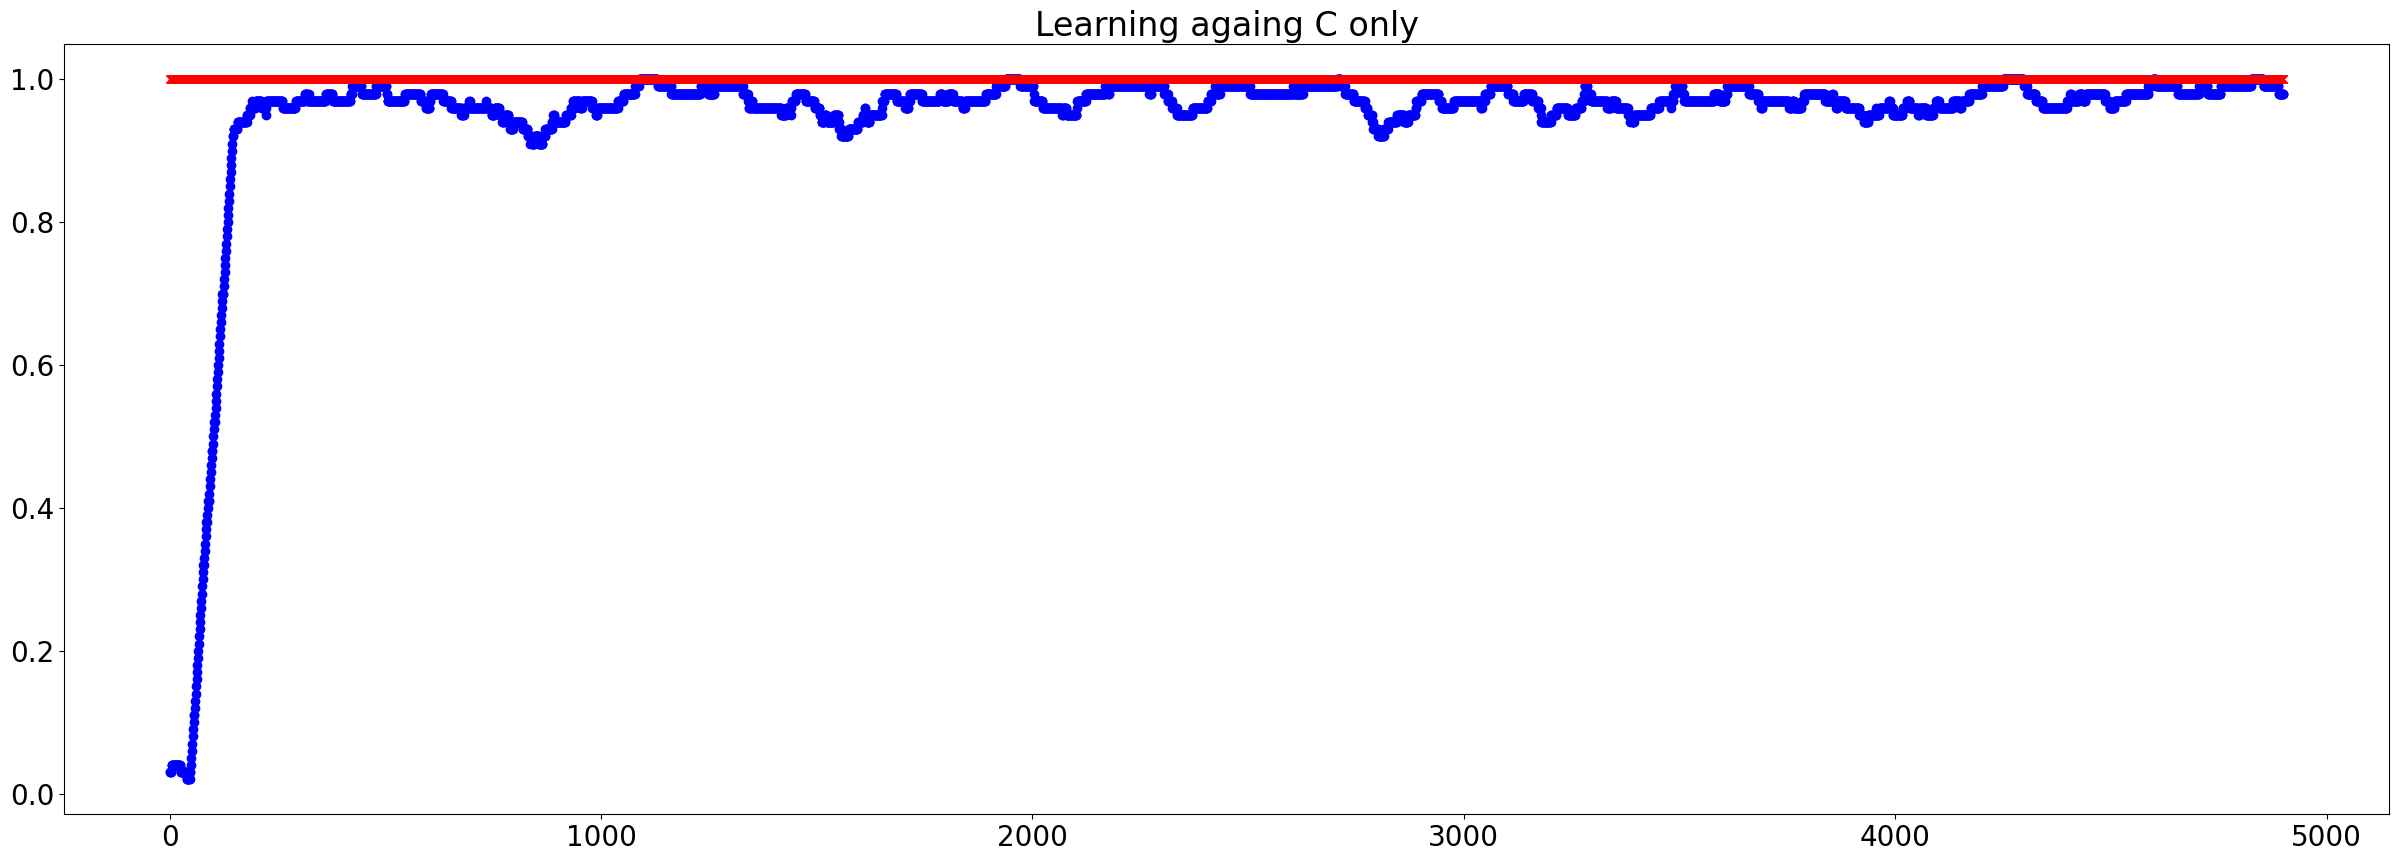

In [34]:
actions = np.array(actions)
plot(actions, 'Learning againg C only')

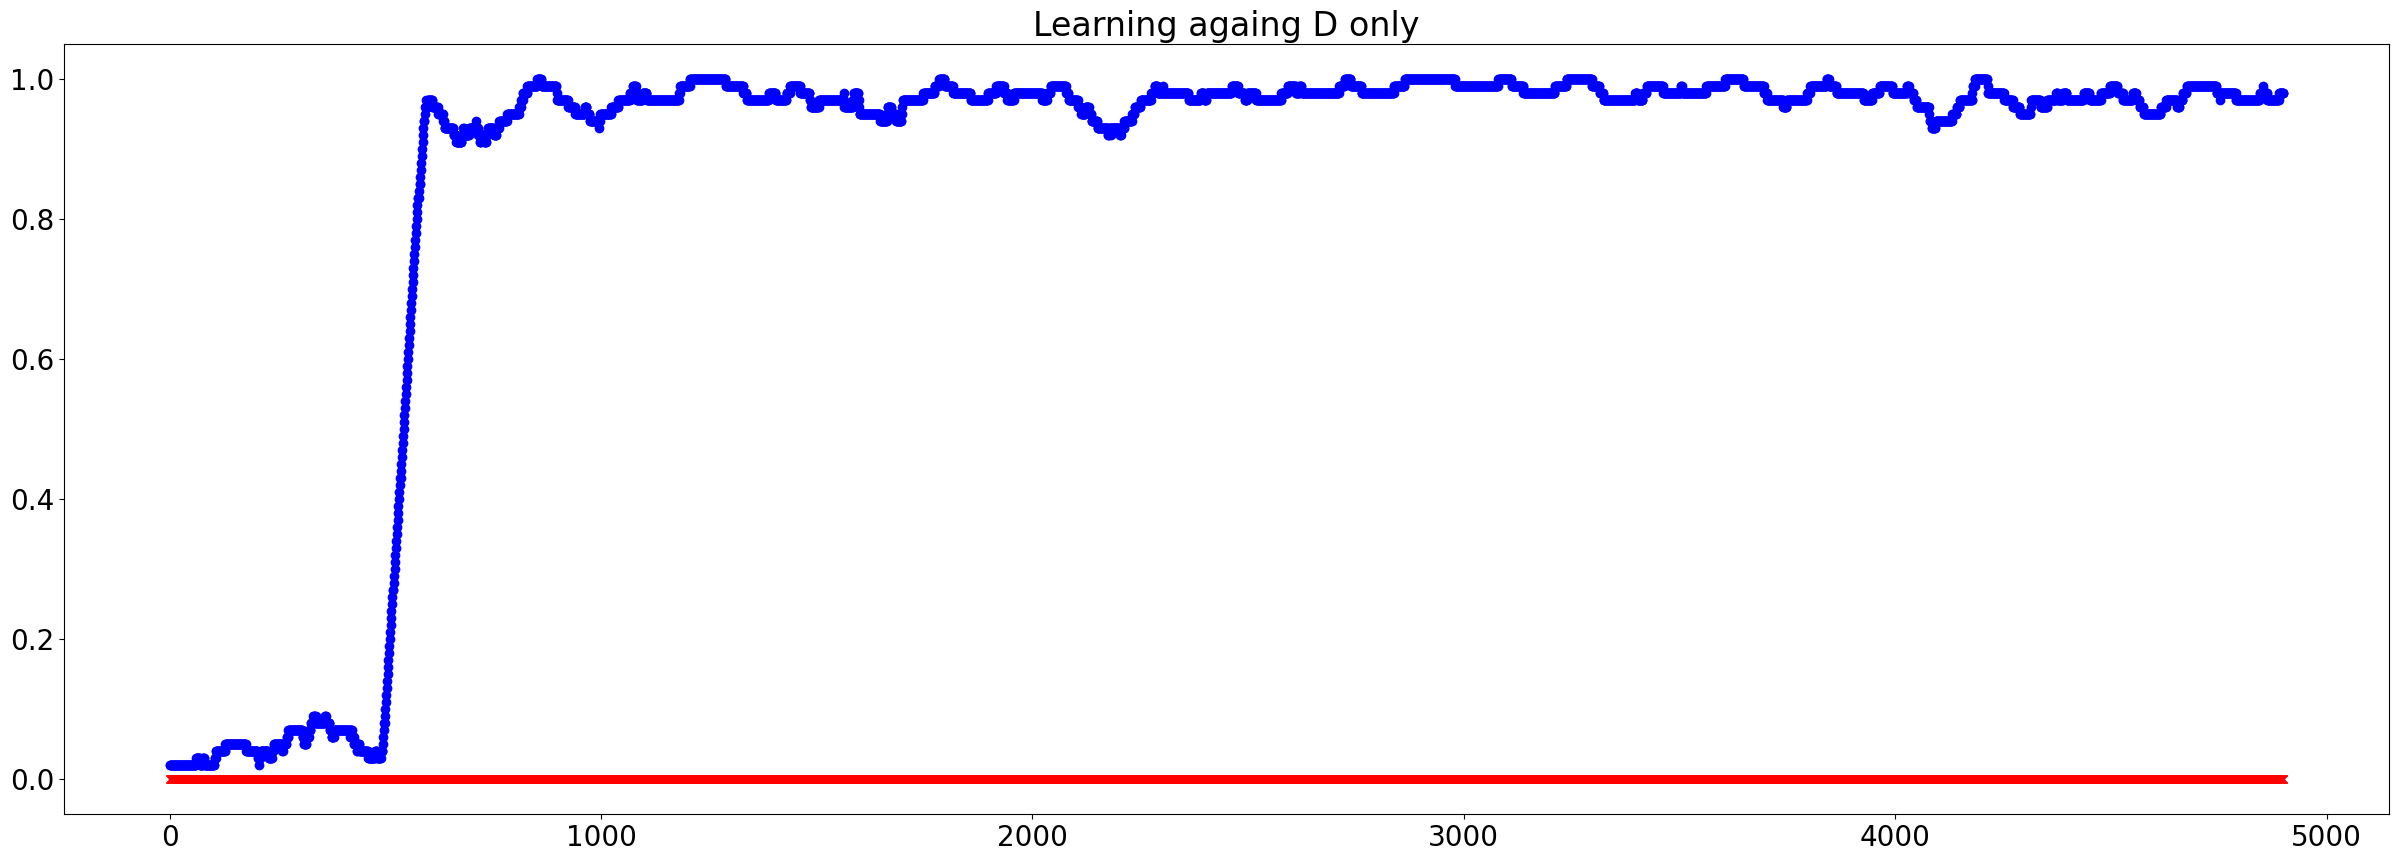

In [39]:
actions = np.array(actions)
plot(actions, 'Learning againg D only')

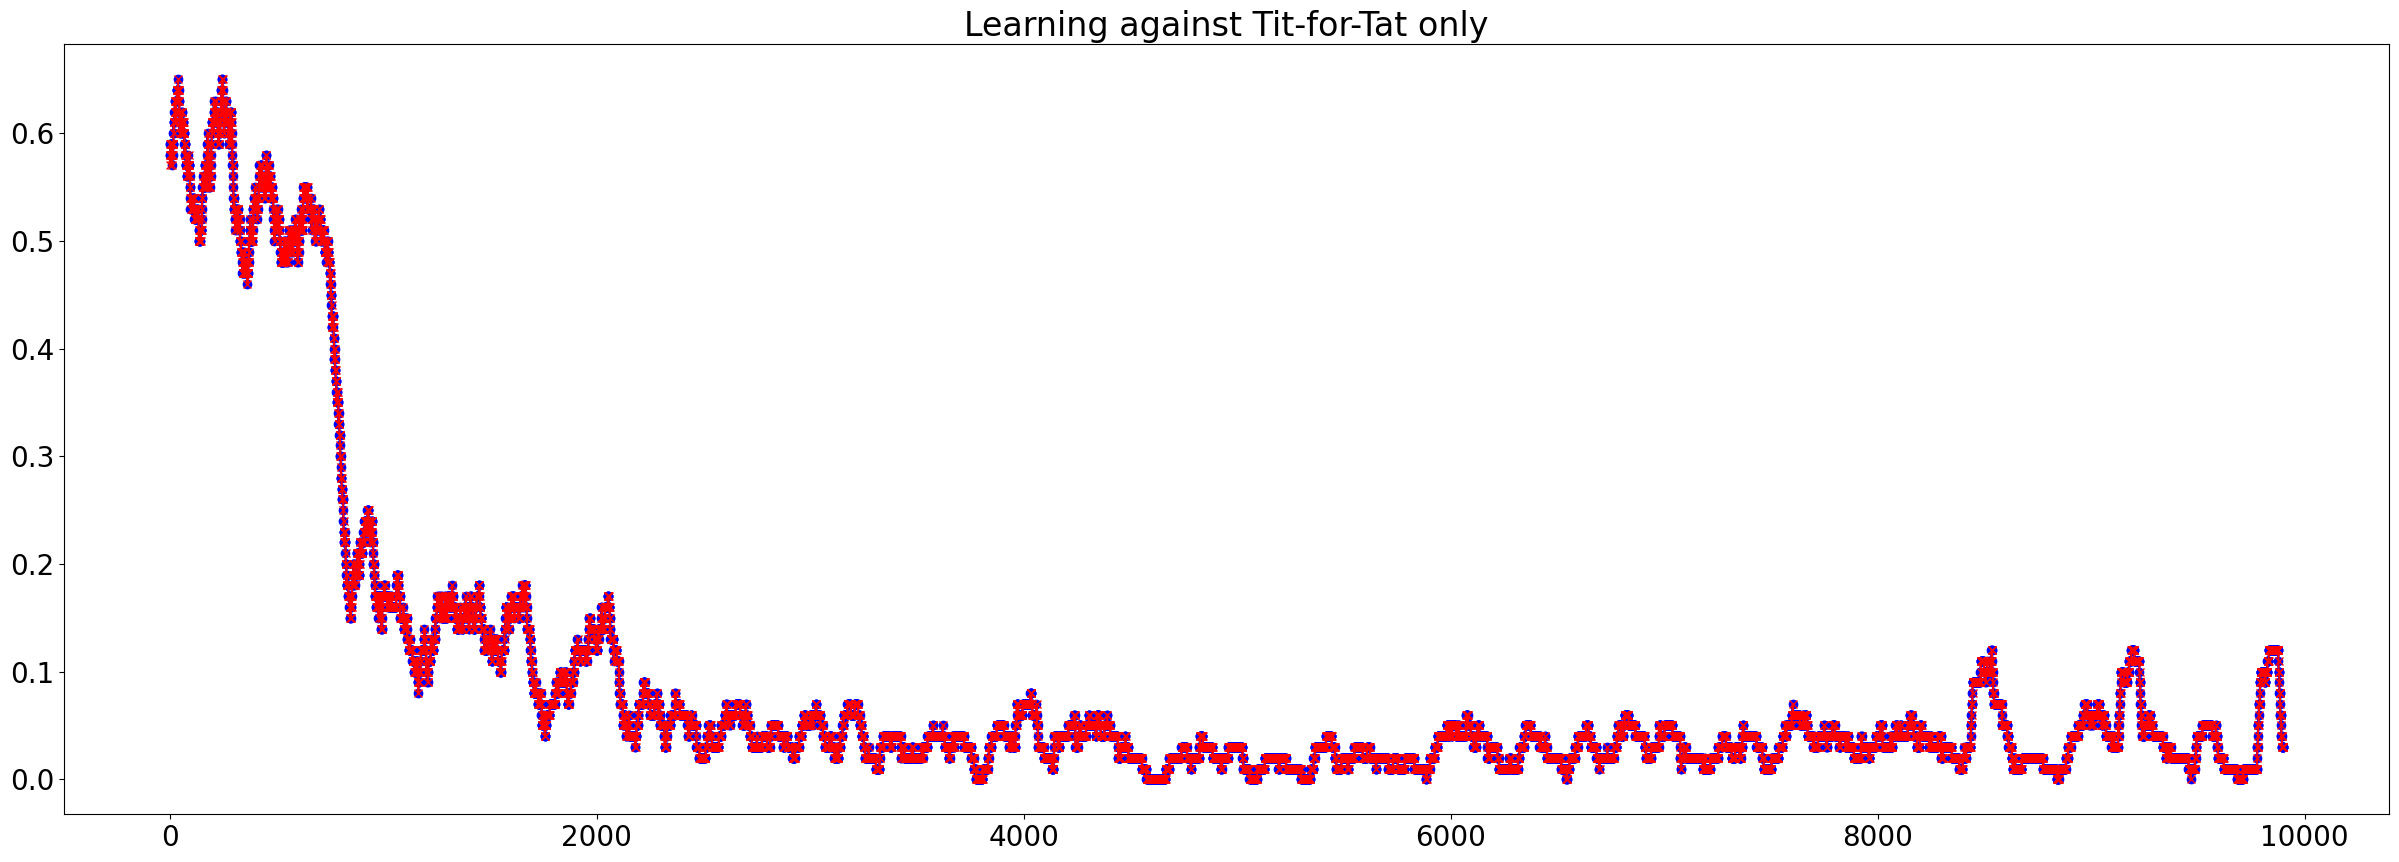

In [77]:
actions = np.array(actions)
plot(actions, 'Learning against Tit-for-Tat only')